<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#About-this-Data" data-toc-modified-id="About-this-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>About this Data</a></span></li><li><span><a href="#Setup-MongoDB-Connection" data-toc-modified-id="Setup-MongoDB-Connection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup MongoDB Connection</a></span></li><li><span><a href="#Creating-a-dataframe-of-Manhattan-Buildings-(from-MongoDB)" data-toc-modified-id="Creating-a-dataframe-of-Manhattan-Buildings-(from-MongoDB)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creating a dataframe of Manhattan Buildings (from MongoDB)</a></span></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Analysis</a></span></li><li><span><a href="#Turning-to-Tableau" data-toc-modified-id="Turning-to-Tableau-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Turning to Tableau</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#First-Note:-Multifamily-Residential-Buildings" data-toc-modified-id="First-Note:-Multifamily-Residential-Buildings-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>First Note: Multifamily Residential Buildings</a></span></li><li><span><a href="#Second-Note:-Public-Facilities-and-Institutions" data-toc-modified-id="Second-Note:-Public-Facilities-and-Institutions-5.0.2"><span class="toc-item-num">5.0.2&nbsp;&nbsp;</span>Second Note: Public Facilities and Institutions</a></span></li><li><span><a href="#Third-Note:-Commercial-Buildings" data-toc-modified-id="Third-Note:-Commercial-Buildings-5.0.3"><span class="toc-item-num">5.0.3&nbsp;&nbsp;</span>Third Note: Commercial Buildings</a></span></li></ul></li></ul></li></ul></div>

# Initial Data Exploration 
March 23rd

## About this Data

**About This Data**: This dataset comes from New York City's public [PLUTO tax lot data](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). These are geographic shapefiles for all 5 boroughs containing all of the lots in NYC as well as information about the building in the lot, the owner, the land use, location, age of building, height of building, etc. Full information regarding the properties of this dataset can be found in the [PLUTO Data Dictionary found here](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=16v2).

This Data was then converted to GeoJSON files (using [ogr2ogr](http://www.gdal.org/ogr2ogr.html)) and then imported into a local MongoDB database for easier management and querying.

## Setup MongoDB Connection

In [3]:
#load python dependencies
import pandas as pd
import pprint as pp
import json
import string
from bson import json_util, ObjectId
from pandas.io.json import json_normalize

In [5]:
#connect to mongodb
from pymongo import MongoClient
client = MongoClient()
db = client.thesis #thesis is the name of the DB we want to access

In [6]:
# get the names of collections in MongoDB
db.collection_names(include_system_collections=False)

['features', 'pluto']

In [7]:
features = db.features

In [8]:
# find one from Manhattan Borough
pp.pprint(features.find_one({'properties.Borough':'MN'}))

{'_id': ObjectId('5ab26407168e4a911bf9c754'),
 'geometry': {'coordinates': [[[-74.00030834856233, 40.7481450543048],
                               [-74.00064119170582, 40.74828487041532],
                               [-74.00045799651024, 40.7485340197782],
                               [-74.00012815525666, 40.748395452549445],
                               [-74.00030834856233, 40.7481450543048]]],
              'type': 'Polygon'},
 'properties': {'APPBBL': 1007230041,
                'APPDate': '11/30/2006',
                'Address': '263 9 AVENUE',
                'AreaSource': '2',
                'AssessLand': 539990,
                'AssessTot': 10493435,
                'BBL': 1007237501,
                'BldgArea': 89203,
                'BldgClass': 'R4',
                'BldgDepth': 100,
                'BldgFront': 87,
                'Block': 723,
                'BoroCode': 1,
                'Borough': 'MN',
                'BsmtCode': '5',
                'BuiltFAR':

In [9]:
# Specify fields wanted
fields = {"properties.Borough" : 1,
            "properties.Address" : 1,
              "properties.BldgArea" : 1,
              "properties.BldgClass" : 1,
              "properties.Block" : 1,
              "properties.BoroCode" : 1,
              "properties.LandUse" : 1,
              "properties.LotArea" : 1,
              "properties.NumFloors" : 1,
              "properties.UnitsRes" : 1,
              "properties.UnitsTotal" : 1 ,
              "properties.OwnerName" : 1,
              "properties.YearBuilt": 1,
              "properties.YearAlter1" : 1,
              "properties.CD" : 1}
            

In [10]:
features.find_one({'properties.Borough':'MN'}, fields)

{'_id': ObjectId('5ab26407168e4a911bf9c754'),
 'properties': {'Address': '263 9 AVENUE',
  'BldgArea': 89203,
  'BldgClass': 'R4',
  'Block': 723,
  'BoroCode': 1,
  'Borough': 'MN',
  'CD': 104,
  'LandUse': '03',
  'LotArea': 9875,
  'NumFloors': 11,
  'OwnerName': None,
  'UnitsRes': 50,
  'UnitsTotal': 50,
  'YearAlter1': 0,
  'YearBuilt': 1914}}

## Creating a dataframe of Manhattan Buildings (from MongoDB)

In [11]:
def mongo_to_dataframe(mongo_data):

        sanitized = json.loads(json_util.dumps(mongo_data))
        
        # unnests the json data
        normalized = json_normalize(sanitized)
        
        #creates a data frame
        df = pd.DataFrame(normalized)
        
        #cleans up column names
        df.columns = df.columns.str.replace('properties.', '')

        return df

In [13]:
df = mongo_to_dataframe(features.find({'properties.Borough':'MN'}, fields))

In [14]:
print(df.shape)
df.head()

(42638, 16)


,_id.$oid,Address,BldgArea,BldgClass,Block,BoroCode,Borough,CD,LandUse,LotArea,NumFloors,OwnerName,UnitsRes,UnitsTotal,YearAlter1,YearBuilt
0,5ab26407168e4a911bf9c754,263 9 AVENUE,89203,R4,723,1,MN,104,03,9875,11.0,None,50,50,0,1914
1,5ab26407168e4a911bf9c755,1592 2 AVENUE,10885,C7,1545,1,MN,108,04,2767,5.0,LL 1592 SECOND AVENUE,16,18,1988,1920
2,5ab26407168e4a911bf9c756,310 EAST 109 STREET,12000,C1,1680,1,MN,111,02,2523,5.0,LA CASA NUESTRA HOUSI,10,10,1997,1910
3,5ab26407168e4a911bf9c757,720 PARK AVENUE,203490,D4,1385,1,MN,108,03,15062,17.0,720 PARK AVE CORP - B,29,32,1985,1928
4,5ab26407168e4a911bf9c758,181 GRAND STREET,2733,S2,236,1,MN,102,04,1425,3.0,GELSO 3 LLC,2,3,0,1910


## Data Analysis

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
landUseMapping = {
  "01": {"name": "One &Two Family Buildings", "color": ""},
  "02": {"name": "Multi-Family Walk-Up Buildings", "color": ""},
  "03": {"name": "Multi-Family Elevator Buildings", "color": ""},
  "04": {"name": "Mixed Residential & Commercial Buildings", "color": ""},
  "05": {"name": "Commercial & Office Buildings", "color": ""},
  "06": {"name": "Industrial & Manufacturing", "color": ""},
  "07": {"name": "Transportation & Utility", "color": ""},
  "08": {"name": "Public Facilities & Institutions", "color": ""},
  "09": {"name": "Open Space & Outdoor Recreation", "color": ""},
  "10": {"name": "Parking Facilities", "color": ""},
  "11": {"name": "Vacant Land", "color": ""}
}

In [15]:
list(df)

['_id.$oid',
 'Address',
 'BldgArea',
 'BldgClass',
 'Block',
 'BoroCode',
 'Borough',
 'CD',
 'LandUse',
 'LotArea',
 'NumFloors',
 'OwnerName',
 'UnitsRes',
 'UnitsTotal',
 'YearAlter1',
 'YearBuilt']

In [55]:
year_grouping = df.groupby(['YearBuilt', 'LandUse'], as_index= False)\
    .size()\
    .to_frame(name = 'count')\
    .reset_index()


In [72]:
year_grouping = year_grouping[year_grouping.YearBuilt > 0]

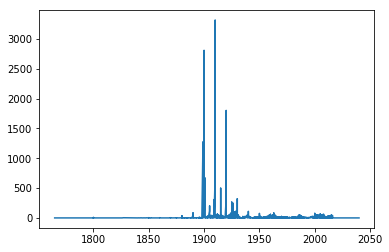

In [73]:
fig, ax = plt.subplots()
ax.plot(year_grouping.YearBuilt, year_grouping['count'])

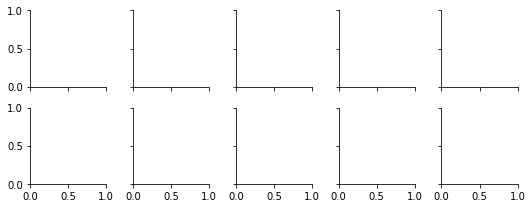

In [74]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(year_grouping, col="LandUse"
                     , hue="LandUse"
                     , col_wrap=5
                     , size=1.5)

In [75]:
# Draw a line plot to show the trajectory of each random walk
# grid.map(plt.plot, "YearBuilt", "count", marker="o", ms=4)

ValueError: Axes instance argument was not found in a figure.

## Turning to Tableau

I decided to go back to my comfort zone of Tableau for some rapid prototyping to get a feel for how the data looks. I would have loved to continue purely in Python as I think that would show a higher degree of data wrangling mastery and I think that I will get back to it at some point. But specifically for tonight, as it is getting later, I wanted to get some quick intuition for what is happening with the PLUTO tax lot data. 

My initial questions for this round revolved around exploring the relationship between different land use developments over time. 


This first series looks at different land use classes over time. Here, each row is one land use and the x-leftAxis is time ('YearBuilt' binned with 10 years per group). The line in each pane is representing the count of buildings in that time period, and the area behind it represents the sum of the building area during that period. Together they do show interesting patterns of development waxing and waning at different times. 

One thing to note here is that I grouped a few land use classes together for ease of reading. For example, I grouped *"02":"Multi-Family Walk-Up Buildings"* and *"03": "Multi-Family Elevator Buildings"* into 'Multifamily Residential." 

![](../assets/images/tableau-land-use-over-time.png)


#### First Note: Multifamily Residential Buildings
The following are some things I noted initially:
* (pink-top) for the 'Multifamily Residential' (my grouped class), has 2 significant peaks of development and then it tends to trail off. I wonder what those periods are due to and if they also are showing something about two distinct regions of development. 

From there I started wondering if perhaps my grouping was too hasty and that maybe the two peaks were actually 1 for each multifamily residential type.
![](../assets/images/tableau-multifamily-split.png)


The top row shows land use class '02' (the walk up buildings) and the bottom row '03' (the elevator buildings). My hunch does seem to be semi-correct. The second peak I noticed earlier does now appear to be the rise of the elevator buildings as they replaced the walk-ups (very logical). 

Interesting to me is the first bump in the elevator class -- I wonder if the difference between the walkups and the elevator buildings can be explained by region. It is possible that certain wealthy regions started building elevator buildings while others were still developing walkups. Something to look more into at a later point should it prove relevant. 

![](../assets/images/tableau-land-use-over-time2.png)


#### Second Note: Public Facilities and Institutions

There is some interesting activity here as well as it seems that there were two great periods of development in Public Facilities and Institutions (one around 1900 and another around 1960). 

In 1900-1910 there were 381 buildings built (that still exist today! remember, we are always looking relative to our *current* urban landscape), taking up over 13.3 million square feet. When we look at building area (also known as total gross square feet, which includes stairwells, halls, elevator shafts, attics and extensions such as attached garages.) then we are looking at nearly 30 million square feet just in those 10 years.

In the 1960's, there was another boom of public facility development with 175 buildings built, taking up nearly 8 million square feet in lot area, and nearly 23 million square feet of building area. This period seems mainly dominated by education centers, parks and hospitals. 

This makes me wonder about the following things: 

* What are these institutions -- from the area that they take up: I am sure that they are incredibly salient to us today. Pulling up a list of these, and sorting them by Lot Area, I am struck by the fact that most of them were either **educational facilities** (Columbia University) or **religious centers** (lots of churches).

![](../assets/images/tableau-1900-public-facillities-list.png)

* What was happening in the 1960s? Looking at the top buildings from that period showed a different composition of buildings. We still see a lot of Department of **Education** owned buildings, but now instead of religious centers, we are seeing more **parks** and **hospitals**. 

![](../assets/images/tableau-1960-public-facillities-list.png)


* Looking purely at the counts of buildings (see below), there seems to be a kind of **waning periodicity** at play where every **40 years** there is another peak, but over time these peaks are decreasing. This decrease also makes sense, since as time passes, more and more land is developed and less needs to be build. 

![](../assets/images/tableau-public-facillities-over-time-cnts.png)

* Currently what is happening? First one on the list is owned by DASNY -- John Jay College of Criminal Justice. Mostly **education** still and **cultural centers, like museums**

**DASNY** - "The Dormitory Authority of the State of New York provides construction, financing, and allied services which help provide the foundation for the healthy, educated and resilient communities that make New York thrive."


![](../assets/images/tableau-2010-public-facillities-list.png)


![](../assets/images/tableau-land-use-over-time2-vertical.png)

#### Third Note: Commercial Buildings

Big difference between LotArea and Building Area

![](../assets/images/tableau-land-use.png)

![](../assets/images/tableau-land-use-%-of total.png)

![](../assets/images/tableau-land-use-stacked-bar.png)